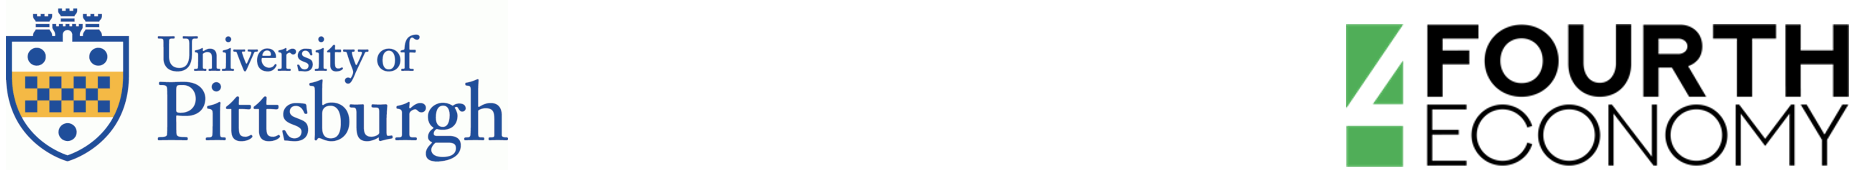

In [2]:
# Display logos
library("IRdisplay")
display_png(file="logos.png")

In [3]:
# Add "Toggle code" button
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click to toggle on/off the raw code.">
 </form>'
)

# US Affordable Housing Shortage

**Natalee Morris, Gayatri Pai, and Mason Putt**

### Project Overview

The Covid-19 global pandemic has brought about a wave of joblessness and housing insecurity for millions of American families. This analysis aims to explore the extent to which this negative unemployment shock causes housing displacement among renters in all US counties, specifically in counties that were already facing housing shortages prior to the pandemic. We use data ranging from 2008-2017 to show how higher unemployment and housing affordability gaps leads to higher rates of evictions, and how this effect is different across counties with different rurality or racial breakdowns.

Studying evictions in the US is still in its infancy.  Most impoverished people rent their households, and affordable housing in the US is scarce.  Launched in 2017, Princeton University's Eviction Lab became the first resource for data to study evictions at a national scale.  In order to tackle these issues and create equitable communities, we must effectively examine eviction rates and the conditions that lead households to get evicted in the first place.  Doing so will allow our local and national officials to make data-driven decisions that combat the equitability gap that plagues this country.

This is an academic project completed by members of the [University of Pittsburgh's MS in Quantitative Economics program](https://www.mqe.pitt.edu/), advised by Pittsburgh consulting firm [Fourth Economy](https://www.fourtheconomy.com/).

### Data Description

We define housing affordability statistics using data from the **[Comprehensive Housing Affordability Strategy](https://www.huduser.gov/portal/datasets/cp.html#2006-2017_data)**, or CHAS, in the form of 5-year estimates from 2008-2012 and 2013-2017. The 2013-2017 period shows the state of a given county's housing market prior to the onset of Covid-19, while the 2008-2012 period gives some insight into how that county responded to the 2008 recession. The latter period gives some intuition as to how a county will respond to an unemployment shock such as 2020's.

This dataset is then merged with data from the following sources, also aggregated into 5-year averages:

- **[Princeton University's Eviction Lab](https://evictionlab.org/map/#/2016?geography=states&type=er)**: Estimates of evictions and demographic information
- **[Economic Research Service](https://www.ers.usda.gov/)** 2015 Database: Binaries to indicate a county's economic typology
- **[ACS School Enrollment Survey](https://www.census.gov/topics/education/school-enrollment.html)**: Estimates of college enrollment in a given county

The following variables are used to define housing markets and local economies:

- *population*: A raw count of the total population
- *unemp_rate*: Unemployed population divided by the total labor force
- *renter_rate*: The proportion of a county's population that rents (rather than owns) housing
- *evict_rate*: Number of evictions divided by number of renters
- *nonwhite_rate*: Proportion of a county's population that is nonwhite
- *r_totalgap_rate*: The proportion of a county's population that does not have affordable rental housing available to them
- *college_rate*: The proportion of a county's population attending college
- *costbur_rate*: The proportion of renters facing cost burden or severe cost burden - spending at least 30% of their income on housing
- *metro*: A binary indicating counties constaining one or more urbanized areas

The full dataset and data dictionary of sources / variable deifnitions can be found at https://github.com/MasonPutt/4E-Capstone-Project. Here, we also provide an identical dataset that forces the data into 1-year estimates rather than 5-year averages. To avoid making false assumptions about the state of housing markets (i.e. assuming identicality in housing markets between 2008 and 2012), our analysis utilizes 5-year averages.

The following gives an example of the data format for the first three counties in the US alphabetically:

**Table 1: Data Format**

In [5]:
options(warn=-1)
options(message=-1)

library(kableExtra)
library(IRdisplay)
library(tidyverse)

# Load data
alldata5yr <-read.csv("https://raw.githubusercontent.com/MasonPutt/4E-Capstone-Project/main/alldata5yr.csv")
kable(head(alldata5yr[c(3,6,22,7,8,9,10,15,17,18,112)],6), format='html') %>%
    as.character() %>%
    display_html() 

# Define options
Pitt.Blue<- "#003594"
Pitt.Gold<-"#FFB81C"

county_state,period,population,unemp_rate,renter_rate,evict_rate,nonwhite_rate,r_totalgap_rate,college_rate,costbur_rate,metro
"Abbeville County, SC",2008-2012,25221.0,0.1178,0.2232,0.0095,0.3090,0.1542,0.0611,0.4286,0
"Abbeville County, SC",2013-2017,24997.0,0.0688,0.2295,0.0418,0.3108,0.2923,0.0616,0.4288,0
"Acadia Parish, LA",2008-2012,61066.2,0.0610,0.3067,0.0079,0.2168,0.1735,0.0350,0.3390,1
"Acadia Parish, LA",2013-2017,62163.0,0.0636,0.2867,0.0220,0.2230,0.1938,0.0344,0.4192,1
"Accomack County, VA",2008-2012,35287.6,0.0705,0.2951,0.0270,0.3900,0.2214,0.0332,0.2918,0
"Accomack County, VA",2013-2017,33115.0,0.0577,0.3001,0.0230,0.3908,0.2783,0.0354,0.4039,0


The main features of the data are described below for all 3,141 geographies (3,006 counties, 14 boroughs, and 11 census areas) that make up the United States in the 2013-2017 period. The median and mean of each variable give us insight into what the average county looks like and provides a starting point for considering the normality assumptions in the modeling process.

**Table 2: Summary Statistics**

In [6]:
library(skimr)
options(scipen = 999)

# Extract only 2013-17 data
recent <- filter(alldata5yr, period=='2013-2017')

# Creates summary table
sumtab <- t(t(skim(recent[c(22,7,8,9,10,15,17,18,112)])))
sumtab <- sumtab[, c(2:3, 7:9, 5, 10:12)]
sumtab <- as.data.frame(sumtab) %>%
    select('Variable'=1,'Number Missing'=2,'Min'=3,'1st Quartile'=4,'Median'=5,'Mean'=6,'3rd Quartile'=7,'Max'=8, 'Distribution'=9)
sumtab[2:7] <- lapply(sumtab[2:7],as.numeric)
kable(sumtab, format = "html") %>%
    as.character() %>%
    display_html() 
     

Variable,Number Missing,Min,1st Quartile,Median,Mean,3rd Quartile,Max,Distribution
population,1,85.0000,11030.000000,25768.0000,100776.6108280,67492.75000,10038388.0000,▇▁▁▁▁
unemp_rate,1,0.0179,0.044100,0.0559,0.0580238,0.06880,0.2350,▇▅▁▁▁
renter_rate,0,0.0588,0.231500,0.2741,0.2865895,0.32480,0.9091,▃▇▁▁▁
evict_rate,542,0.0000,0.004800,0.0121,0.0172846,0.02430,0.1737,▇▁▁▁▁
nonwhite_rate,1,0.0024,0.066475,0.1536,0.2271571,0.34375,0.9905,▇▃▂▁▁
r_totalgap_rate,0,0.0000,0.107100,0.1631,0.1611107,0.21250,0.4609,▃▇▆▁▁
college_rate,3,0.0000,0.030600,0.0406,0.0509359,0.05800,0.5749,▇▁▁▁▁
costbur_rate,0,0.0000,0.305600,0.3685,0.3593675,0.42380,0.6766,▁▂▇▅▁
metro,0,0.0000,0.000000,0.0000,0.3712194,1.00000,1.0000,▇▁▁▁▅


**A note on missing data:**



Of the 6,282 observations (3,141 geographies over two periods), we find 1,066 missing observations for eviction rates. 542 (50.8%) of the missing observations occured in the 2013-2017 time period. 

For simplicity in the modeling process, we assume that the distribution of missing observations is essentialy random. The table below describes the main features of the missing observations from the 2013-2017 period:

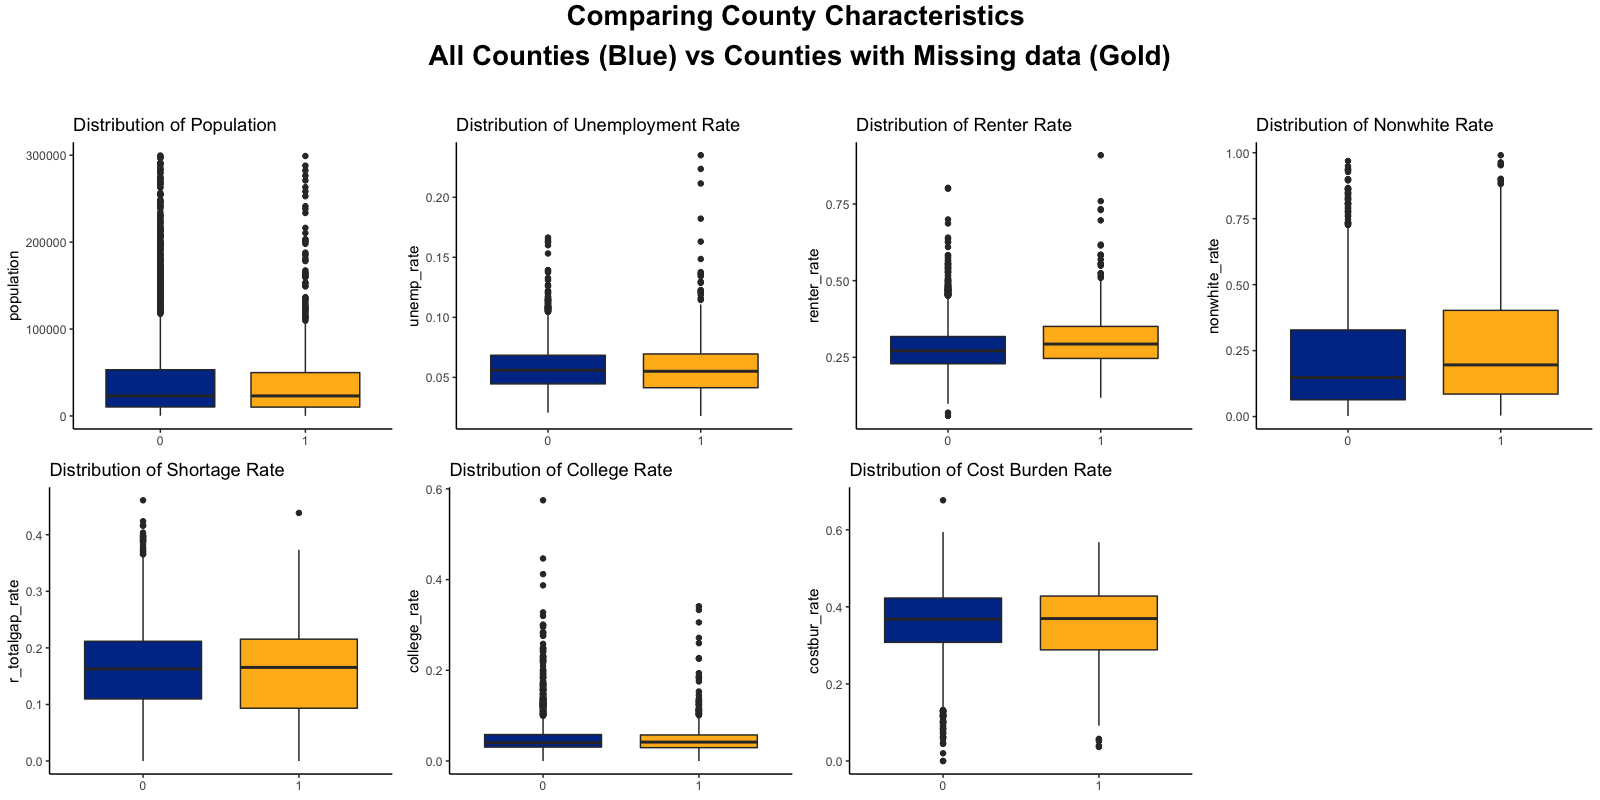

In [7]:
library(ggpubr)

# Creates binary for missing data
recent$missing <- as.integer(complete.cases(recent))
recent$missing <- ifelse(recent$missing==0,1,0)

# Pulls proportion of counties with missing data by state
#aggregate(recent['missing'], list(recent$state), mean)

# Creates boxplots, coloring by missing binary
pop <- ggplot(data=recent, aes(y=population, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Population")+ theme(legend.position = "none", axis.title.x=element_blank()) +
        ylim(c(0,300000))+ scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
un <- ggplot(data=recent, aes(y=unemp_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Unemployment Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
rr <- ggplot(data=recent, aes(y=renter_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Renter Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
nw <- ggplot(data=recent, aes(y=nonwhite_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Nonwhite Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
tgr <- ggplot(data=recent, aes(y=r_totalgap_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Shortage Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
col <- ggplot(data=recent, aes(y=college_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of College Rate")+ theme(legend.position = "none", axis.title.x=element_blank())+ 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))
cb <- ggplot(data=recent, aes(y=costbur_rate, x=as.factor(missing), fill=as.factor(missing))) + 
        geom_boxplot() + theme_classic() + ggtitle("Distribution of Cost Burden Rate")+ theme(legend.position = "none", axis.title.x=element_blank()) + 
        scale_fill_manual(values=c(Pitt.Blue, Pitt.Gold))

options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

# Display boxplots in grid form
bplots <- ggarrange(pop,un,rr,nw,tgr,col,cb, ncol=4, nrow=2)
annotate_figure(bplots,
               top = text_grob("Comparing County Characteristics \nAll Counties (Blue) vs Counties with Missing data (Gold)\n", face = "bold", size = 20)
)

We see very similar measures of spread and central tendency for the characteristics between counties with and without missing eviction data. That being said, the there are geographic trends that exist between counties with missing data. The following are a few disclaimers regarding missing observations:

- The following states have missing data for every county: Alaska, Arkansas, North Dakota, South Dakota
- The following states have missing data for over 50% of counties: Arizona, Maryland, New York
- Eviction Lab has reported that not all records were collectible.  Eviction record policies are strict in certain areas of the country which makes acquiring data impossible.
- Eviction Lab purchased some of their data from LexisNexis which was last updated in 2017 and American Information Research Services (AIRS) which last updated its records in 2018.  It is possible that by now the records have been updated to include more backdated 2008-2017 eviction data.

The following graph shows the distribution of actual eviction rates recorded in the 3,141 geographies over the two time periods. The figure below shows a positive skew of the eviction rates, indicating that a normal curve fit by a linear regression is inaccurate. We also show a beta distribution model, which we believe is a better fit for the data:

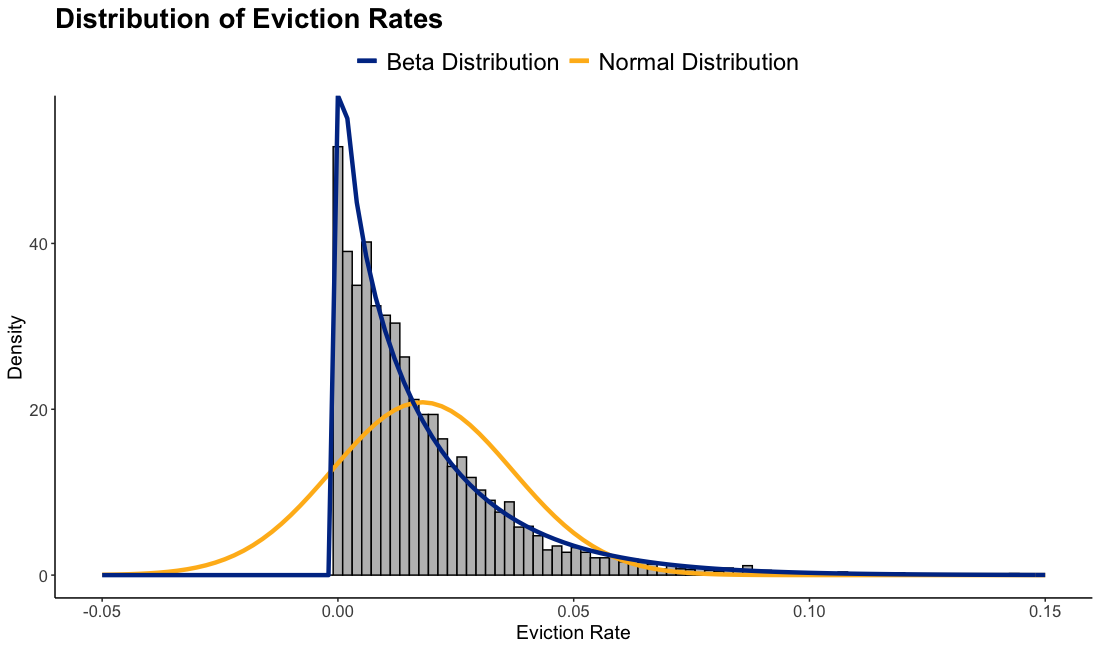

In [9]:
library(EnvStats)
# Pull coefficients to graph beta distribution
betacoefs <- ebeta(na.omit(alldata5yr)$evict_rate, method = "mle")

# Create plot
options(repr.plot.width = 11, repr.plot.height = 6.5)
ggplot(alldata5yr, aes(x=evict_rate)) + 
    geom_histogram(aes(y = ..density..), bins = 100, fill='grey', col='black') + xlim(c(-0.05, 0.15)) +
    stat_function(fun = dnorm, args = list(mean(na.omit(alldata5yr)$evict_rate), sd(na.omit(alldata5yr)$evict_rate)), aes(colour = Pitt.Gold), size=1.5) +
    stat_function(fun = dbeta, args = list(betacoefs$parameters[1], betacoefs$parameters[2]), aes(colour = Pitt.Blue), size=1.5) + ylab("Density")+ xlab("Eviction Rate")+
    theme_classic() + ggtitle("Distribution of Eviction Rates") + theme(axis.text=element_text(size=12), plot.title=element_text(size=20,face="bold"),
        axis.title=element_text(size=14)) + 
    scale_colour_manual("", values = c(Pitt.Blue, Pitt.Gold), labels = c("Beta Distribution", "Normal Distribution")) + 
    theme(legend.text = element_text(size = 17), legend.position="top")


### Modeling

We use two types of models to estimate eviction rates within US counties.  Our initial model was a standard OLS model.  We are most interested in the effects of cost burden rate and unemployment rate with respect to predicting eviction rates.

We select controls from an array of variables that are held constant at the county level.  These controls include dummy variables that account for the time period and the region that the county is in. We also control for county-level demographic characteristics.

The OLS model provides us with a preliminary view of how certain factors helped predict eviction rates.  Unfortunately, the model was not an optimal fit to our data.  We then decided to pursue a beta regression model that works best for observations that lie within a 0 to 1 interval.  This model produced similar coefficients as the OLS but with a better fit to our data.

We included an interaction term between our two main effects (cost burden and unemployment) to account for the combined effect of these two factors. 

Note: In our beta regression model, we first transform the dependent variable (eviction rates) to make them abide to the standard unit interval (0,1). This is necessary step mathematically, as the beta distribution bounds estimates to the open (0,1) interval. The transformation we use follows the methods of [Smithson and Verkuilen, 2006](https://pubmed.ncbi.nlm.nih.gov/16594767/): 

$$alt\_evictrate = \frac{(evictrate*(n-1)+0.5)}{n}$$

In the context of our data, this would transform an eviction rate of 0 to 0.00008, or an eviction rate of 0.1 would become 0.10006. This transformation allows the beta model to run without changing the interpretation of the dependent variable.

**Table 3: Eviction Rate Models**

In [11]:
# First, we create regions to be used as fixed effects in modeling

NE.name <- c("Connecticut","Maine","Massachusetts","New Hampshire",
              "Rhode Island","Vermont","New Jersey","New York",
              "Pennsylvania")
 
MW.name <- c("Indiana","Illinois","Michigan","Ohio","Wisconsin",
              "Iowa","Kansas","Minnesota","Missouri","Nebraska",
              "North Dakota","South Dakota")
 
S.name <- c("Delaware","District of Columbia","Florida","Georgia",
             "Maryland","North Carolina","South Carolina","Virginia",
             "West Virginia","Alabama","Kentucky","Mississippi",
             "Tennessee","Arkansas","Louisiana","Oklahoma","Texas")
 
W.name <- c("Arizona","Colorado","Idaho","New Mexico","Montana",
             "Utah","Nevada","Wyoming","Alaska","California",
             "Hawaii","Oregon","Washington")

region.list <- list(
     Northeast=NE.name,
     Midwest=MW.name,
     South=S.name,
     West=W.name)

alldata5yr$region <- sapply(alldata5yr$state, 
                      function(x) names(region.list)[grep(x,region.list)])
alldata5yr$region <- as.character(alldata5yr$region)

In [12]:
library(lfe)
library(xtable)
library(IRdisplay)
library(repr)
library(mfx)
library(betareg)
library(texreg)

alldata5yr$alt_evrate <- (alldata5yr$evict_rate * (6281) + 0.5) / 6282

# Run models
ols <- lm(evict_rate ~ costbur_rate+unemp_rate, data=alldata5yr)
ols_int <- lm(evict_rate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate, data=alldata5yr)
ols_controls <- lm(evict_rate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)
betam <- betamfx(alt_evrate ~ costbur_rate+unemp_rate, data=alldata5yr)
betam_int <- betamfx(alt_evrate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate, data=alldata5yr)
betam_controls <- betamfx(alt_evrate ~ costbur_rate+unemp_rate+costbur_rate*unemp_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)

# Extracts predictions (using same beta model, different formatting to use predict command)
beta_controls <- betareg(alt_evrate ~ costbur_rate+unemp_rate+unemp_rate*costbur_rate+metro+nonwhite_rate+college_rate+as.factor(period)+as.factor(region), data=alldata5yr)
alldata5yr$pred_evrate <- predict(beta_controls, alldata5yr)
alldata5yr$pred_error <- alldata5yr$pred_evrate-alldata5yr$evict_rate

# Creates results table
a <- screenreg(list(ols, ols_int, ols_controls, betam, betam_int, betam_controls), custom.header = list("OLS: Eviction Rate"=1:3, "Beta Reg: Alt Eviction Rate"=4:6),
             custom.model.names = c("    OLS", "Interaction", " Controls", "    Beta", "Interaction", "Controls"), digits=3,
             custom.coef.map = list("costbur_rate" = "Proportion Cost Burdened", "unemp_rate" = "Unemployment Rate", "costbur_rate:unemp_rate" = "Interaction (Unemp*CostBur)", "metro" = "Metropolitan", "nonwhite_rate" = "Proportion Nonwhite", "college_rate"="Proportion in College", "as.factor(period)2013-2017"="2013-17 Period"),
             groups = list("Main Effects" = 1:3, "Controls" = 4:7), inner.rule = "_", outer.rule = "=",
             include.rsquared = F, include.pseudors = F, custom.gof.rows=list("Region Fixed Effects" = c("No", "No", "Yes", "No", "No", "Yes")), reorder.gof = c(1, 3, 2,4), column.spacing=0)
write.table(a, quote = FALSE, eol='', row.names=FALSE, col.names=FALSE)


                                        OLS: Eviction Rate               Beta Reg: Alt Eviction Rate      
                               ___________________________________________________________________________
                                   OLS     Interaction  Controls       Beta     Interaction  Controls     
__________________________________________________________________________________________________________
Main Effects                                                                                              
                                                                                                          
    Proportion Cost Burdened      0.077 ***   0.059 ***   0.028 ***    0.060 ***    0.071 ***    0.057 ***
                                 (0.003)     (0.007)     (0.007)      (0.002)      (0.005)      (0.005)   
    Unemployment Rate             0.029 **   -0.070      -0.133 ***    0.011        0.075 **     0.053    
                                 (0.

The dataframe below is comprised of summary statistics of the actual eviction rates, predicted eviction rates, and their difference. The means of the actual and predicted eviction rates are nearly identical.  The table also displays a small error that is normally distributed around mean 0. Overall, the model gives a mean squared error of 0.0002.

In [36]:
# Calculate MSE:
#recent_nona <- na.omit(recent)
#mean((recent_nona$evict_rate - recent_nona$pred_evrate)^2)

In [15]:
recent <- filter(alldata5yr, period=='2013-2017')
df <- data.frame(recent$county_state, recent$evict_rate, recent$pred_evrate, recent$pred_error)

kable(summary(df[2:4]), col.names=c('Actual Eviction Rates','Predicted Eviction Rates','Prediction Error'), format = "html") %>%
    as.character() %>%
    display_html() 

,Actual Eviction Rates,Predicted Eviction Rates,Prediction Error
,Min. :0.0000,Min. :0.002753,Min. :-0.1585
,1st Qu.:0.0048,1st Qu.:0.011660,1st Qu.:-0.0054
,Median :0.0121,Median :0.015989,Median : 0.0041
,Mean :0.0173,Mean :0.017536,Mean : 0.0004
,3rd Qu.:0.0243,3rd Qu.:0.022811,3rd Qu.: 0.0096
,Max. :0.1737,Max. :0.047190,Max. : 0.0345
,NA's :542,NA's :4,NA's :543


To predict eviction rates in each county in the 2013-2017 period, we decided to use the beta regression model that incorporates the interaction term, controls, and region fixed effects. The following graph visualizes the inteaction between cost burden and unemployment in this model. We see that in counties with higher rates of cost burden, a negative unemployment shock increases predicted evictions by a wider margin.

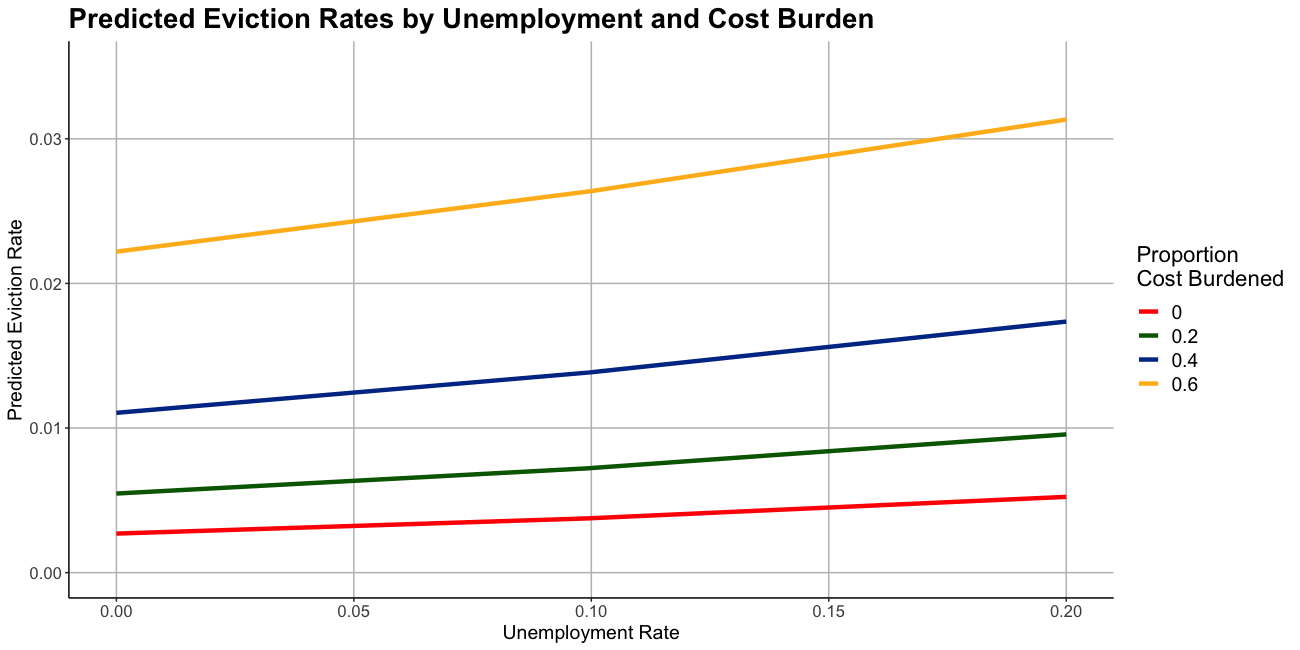

In [33]:
options(warn=-1)

library(sjPlot)
options(repr.plot.width = 13, repr.plot.height = 6.5)
suppressMessages(plot_model(beta_controls, type = "pred", terms = c("unemp_rate","costbur_rate[0,0.2,0.4,0.6]"), ci.lvl = NA, line.size=1.5)+ylim(c(0,0.035)) + 
    theme_classic() + ggtitle("Predicted Eviction Rates by Unemployment and Cost Burden") + xlab('Unemployment Rate') + ylab('Predicted Eviction Rate') +
    theme(axis.text=element_text(size=12), plot.title=element_text(size=20,face="bold"), axis.title=element_text(size=14), legend.title=element_text(size=16)) + 
    scale_colour_manual("Proportion \nCost Burdened", values = c("red", "darkgreen", Pitt.Blue, Pitt.Gold), labels = c("0", "0.2", "0.4", "0.6")) + 
    theme(legend.text = element_text(size = 14)) + theme(panel.grid.major = element_line(colour = "grey")))


In [42]:
Allegheny <- filter(recent, county_state=="Allegheny County, PA")
Allegheny$unemp_rate <- 0.0535
Allegheny2 <- Allegheny
Allegheny2$unemp_rate <- 0.1535

#predict(beta_controls, Allegheny)
#predict(beta_controls, Allegheny2)



To predict the effect of an unemployment shock, the unemployment rate variable must be updated, and the model can be run accordingly. In Allegheny County, PA, the uenmployment rate for 2013-2017 was 0.0535. If this were to increase by 10% to 0.1535, the predicted eviction rate would increase from 1.75% to 2.19%, an increase of 8,290 rental households. 

### Interactive Visualizations

One key component of this project is visualizing shortages in housing affordability. Affordability is defined in the CHAS dataset relative to the HUD Area Median Family Income (HAMFI). A rental unit is considered affordable if the renter is not spending more than 30% of their income on housing. 

We calculate shortage by the number of renters who “up-buy” (rent above what is considered affordable), minus affordable vacancies. Therefore, the shortage only captures the lack of availability of rental housing units.

The housing affordability map for 2013-2017 can be viewed [here](https://htmlpreview.github.io/?https://github.com/MasonPutt/4E-Capstone-Project/blob/main/Shortage_map.html). This map shows that there are high concentrations of housing shortages on both the western and northeastern coasts.

For more specific state and county characteristics, you can view our [interactive dashboard](https://datastudio.google.com/embed/reporting/ba1b4842-a802-43b2-accb-c09e67854e96/page/jhJFC).

### Project Reflection

**Data**

Through data cleaning and analysis we arrived at a model that best fits and estimates eviction rates in US counties. We completed the data cleaning process on RStudio, documented [here](https://github.com/MasonPutt/4E-Capstone-Project/blob/main/Capstone%20Data%20Cleaning%20Counties.Rmd). This involved accumulating data from multiple sources, manipulating them into a merged format, and aggregating them to assure data compatibility. This process tested our coding skills, and forced us to find unique solutions to incombatibility issues that came up. 

**Modeling**

Finding a model that really fit our data proved to be challenging.  Starting with the OLS model proved to be a good first step but it was clear that the approach was not optimal.  After some trial and error we settled on a Tobit model which censored the data between 0 and 1, fitting the proportional nature of our variables.  It was not until creating predictions that problems arose.  This caused us to shift to a beta regression close to the deadline.  Ultimately beta regression was the best model choice but it was enlightening how quickly things can change in a project.  This project has shown that it is always useful to revisit different aspects of the project even if they are considered “complete”.  You can always go back and improve on thing and it may illuminate some underlying problem that can be fixed soon.

**Visualization**

The data visualization portion of the projected presented an opportunity to learn more about Python and Google Data Studio. The interactive map of the US is an example of using Python’s Plotly package, which includes a choropleth map structure. We additionally used Google Data Studio in order to make an intuitive dropdown menu to view housing affordability at different income levels. There are several ways to go about visualization and this project was a great opportunity to learn about different tools.

**Putting it Together**

As a whole this project was very informative and stimulating.  What surprised me the most was how effective group work was.  We each had our roles to play in this project but meeting as a group helped work through some of the bumps in the roads we hit individually.

### Suggestions for Further Research

- Aggregation at a city or tract level
- Further exploration of potential controls in the prediction of eviction rates
- Accounting for more localized policy differences and effects
- Considering distance to employment and affordable vacancies
- Searching for more complete measures of eviction rates